# Import packages & functions

In [ ]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils

import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
parent_dir = os.path.dirname(parent_utils_path)  # Extract directory
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
spec.loader.exec_module(preproc)

# Can run a SLURM job array to train many models with different random seed values
try:
    seed = int(os.environ["SLURM_ARRAY_TASK_ID"])
    print(f"using random seed {seed} in SLURM job {seed} of array")
except:
    print("SLURM random seed indices not provided; using random seed = 0")
    seed = 0

if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

importing modules
SLURM random seed indices not provided; using random seed = 0


# Princeton data prep

## Load Data & Design

In [ ]:
sub = 'sub-005'
session = 'all'
task='task-C_'  # '' (empty string) normally, task-A_ or similar otherwise
func_task_name = 'C'  # 'study' or 'A'; used to search for functional run in bids format
resample_voxel_size = False

# settings for multiple sessions
if session == "all":
    ses_list = ["ses-01", "ses-02"]  # list of actual session IDs
    design_ses_list = ["ses-01", "ses-02"]  # list of session IDs to search for design matrix
else:
    ses_list = [session]
    design_ses_list = [session]
    
multi_session = False  # do you want to run GLMsingle on multiple sessions for this subject? 
ref_session = None  # None or 'ses-xx'; use the T1 from the reference session; use this only if the current session doesn't have a T1
if ref_session is not None: 
    assert multi_session is True
if ref_session is None: ref_session = session

if sub=='sub-001' and session == 'ses-01':
    n_runs=16
elif sub=='sub-002' and session == 'ses-01':
    n_runs=9
elif (sub=='sub-001' and session in ('ses-05')) or (sub=='sub-002' and session in ('ses-02')) or (sub=='sub-004' and session in ('ses-01')):
    n_runs=5
elif sub=='sub-004' and session  == 'ses-02':
    n_runs = 12
elif sub=='sub-004' and session == 'all':
    n_runs = 17
    runs_per_session = {
    "ses-01": 5,
    "ses-02": 12
    }
elif sub=='sub-005' and session in ('ses-01', 'ses-02', 'ses-03'):
    n_runs=11
elif sub=='sub-005' and session == 'all':
    n_runs=22
    runs_per_session = {
    "ses-01": 11,
    "ses-02": 11
    #, "ses-03": 11
    }
else:
    raise Exception("undefined subject and/or session")
runs_per_session = {session: n_runs} if not multi_session else runs_per_session
if multi_session: assert runs_per_session is not None
print(n_runs, "functional runs")
train_test_split = 'MST' # 'orig'
remove_close_to_MST = False
remove_random_n = False
# if remove_close_to_MST or remove_random_n:
#     assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

# if remove_random_n:
#     assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
#     n_to_remove = 150

22 functional runs


In [ ]:
session_label = preproc.get_session_label(ses_list)

In [ ]:
glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{session_label}_task-{func_task_name}"
print(glmsingle_path)
assert os.path.exists(glmsingle_path)
designdir = "/home/ri4541/real_time_mindEye2"

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01-02_task-C


In [7]:
def process_images(image_names, unique_images, remove_close_to_MST=False, remove_random_n=False, imgs_to_remove=None, sub=None, session=None):
    image_idx = np.array([])
    vox_image_names = np.array([])
    all_MST_images = {}
    
    for i, im in enumerate(image_names):
        if im == "blank.jpg" or str(im) == "nan":
            continue
        
        vox_image_names = np.append(vox_image_names, im)
        
        if remove_close_to_MST and "closest_pairs" in im:
            continue
        
        if remove_random_n and im in imgs_to_remove:
            continue
        
        image_idx_ = np.where(im == unique_images)[0].item()
        image_idx = np.append(image_idx, image_idx_)
        
        if sub == 'ses-01' and session in ('ses-01', 'ses-04'):
            if ('w_' in im or 'paired_image_' in im or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', im) 
                or re.match(r'images/\d{1,2}_\d{1,3}\.png$', im)):
                all_MST_images[i] = im
        elif 'MST' in im:
            all_MST_images[i] = im
    
    image_idx = torch.Tensor(image_idx).long()
    unique_MST_images = np.unique(list(all_MST_images.values()))
    
    MST_ID = np.array([], dtype=int)
    if remove_close_to_MST:
        close_to_MST_idx = np.array([], dtype=int)
    if remove_random_n:
        random_n_idx = np.array([], dtype=int)
    
    vox_idx = np.array([], dtype=int)
    j = 0  # Counter for indexing vox based on removed images
    
    for i, im in enumerate(image_names):
        if im == "blank.jpg" or str(im) == "nan":
            continue
        
        if remove_close_to_MST and "closest_pairs" in im:
            close_to_MST_idx = np.append(close_to_MST_idx, i)
            continue
        
        if remove_random_n and im in imgs_to_remove:
            vox_idx = np.append(vox_idx, j)
            j += 1
            continue
        
        j += 1
        curr = np.where(im == unique_MST_images)
        
        if curr[0].size == 0:
            MST_ID = np.append(MST_ID, len(unique_MST_images))  # Out of range index for filtering later
        else:
            MST_ID = np.append(MST_ID, curr)
    
    assert len(MST_ID) == len(image_idx)
    
    pairs = utils.find_paired_indices(image_idx)
    pairs = sorted(pairs, key=lambda x: x[0])
    
    return image_idx, pairs

In [8]:
image_idx_list = []
pairs_list = []
for s in ses_list:
    _, _, _, _, image_names, unique_images, _ = preproc.load_design_files(
        sub=sub,
        session=s,
        func_task_name=func_task_name,
        designdir=designdir,
        design_ses_list=list(s)
    )

    image_idx, pairs = process_images(image_names, unique_images)
    image_idx_list.append(image_idx)
    pairs_list.append(pairs)

Data shape: (780, 122)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Total number of images: 770
Number of unique images: 532
Data shape: (780, 122)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-02.csv
Total number of images: 770
Number of unique images: 532


In [9]:
def get_betas(path):
    glmsingle = np.load(path, allow_pickle=True) 
    return glmsingle['betasmd'].T

### Load nsdgeneral ROI

creating multisession brain mask
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_brain.nii.gz
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-02_task-C/sub-005_ses-02_task-C_brain.nii.gz
intersected brain masks from ['ses-01', 'ses-02']
Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -76.29234314]
 [  0.           2.           0.         -84.79180908]
 [  0.           0.           2.         -62.80359268]
 [  0.           0.           0.           1.        ]]

There are 180856 voxels in the included brain mask

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_nsdgeneral.nii.gz
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-02_task-C/sub-005_ses-02_task-C_nsdgeneral.nii.gz
intersected nsdgeneral roi masks from ['ses-01', 'ses-02']


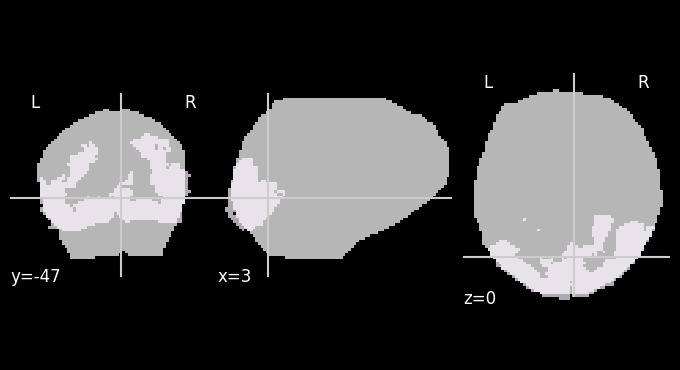

In [10]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi
from nilearn.masking import intersect_masks
import nilearn

# avg_mask=nib.load(f'{sub}_ses-01_brain.nii.gz')
if session == "all":
    print('creating multisession brain mask')
    mask_imgs = []
    for ses in ses_list:
        mask_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses}_task-{func_task_name}/{sub}_{ses}_task-{func_task_name}_brain.nii.gz"

        print(mask_path)
        assert os.path.exists(mask_path)
        mask_imgs.append(mask_path)

    func_masks = [nilearn.image.load_img(mask) for mask in mask_imgs]
    avg_mask = intersect_masks(func_masks, threshold=0.5, connected=True)
    print(f'intersected brain masks from {ses_list}')

else:
    print('loading single session brain mask')
    avg_mask=nib.load(f'{glmsingle_path}/{sub}_{session}_brain.nii.gz')
    # avg_mask=nib.load(f'masks/{sub}_{session}_brain.nii.gz')

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

nsd_masks = []
for ses in ses_list:
    mask_name = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses}_task-{func_task_name}/{sub}_{ses}_task-{func_task_name}_nsdgeneral.nii.gz"
    print(mask_name)
    assert os.path.exists(mask_name)
    nsd_masks.append(mask_name)

nsd_masks = [nilearn.image.load_img(mask) for mask in nsd_masks]
roi = intersect_masks(nsd_masks, threshold=0.5, connected=True)
print(f'intersected nsdgeneral roi masks from {ses_list}')

plot_roi(roi, bg_img=avg_mask)
plt.show()

In [11]:
if session == "all":
    vox_list = []
    for s in ses_list:
        path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{s}_task-{func_task_name}/TYPED_FITHRF_GLMDENOISE_RR.npz"
        vox_list.append(get_betas(path))
        
        print(f"Loaded session: {s} | Current shape: {vox_list[-1].shape}")

Loaded session: ses-01 | Current shape: (693, 1, 1, 182242)
Loaded session: ses-02 | Current shape: (693, 1, 1, 183159)


In [12]:
if session == 'all':
    masked_betas = []
    for i, s in enumerate(ses_list):
        v = nilearn.masking.unmask(vox_list[i][:,0,0], func_masks[i])
        final_mask = nilearn.masking.intersect_masks([avg_mask, roi])
        masked_betas.append(nilearn.masking.apply_mask(v, final_mask))
        
    vox = np.concatenate(masked_betas)
    print('vox shape:', vox.shape)

vox shape: (1386, 19173)


In [13]:
def compute_vox_rels(vox, pairs, sub, session):
    pairs = np.array([[pair[0], pair[1]] for pair in pairs])
    
    vox_pairs = utils.zscore(vox[pairs])
    rels = np.full(vox.shape[-1], np.nan)
    for v in tqdm(range(vox.shape[-1])):
        rels[v] = np.corrcoef(vox_pairs[:, 0, v], vox_pairs[:, 1, v])[1, 0]
    
    print("rels", rels.shape)
    assert np.sum(np.all(np.isnan(rels))) == 0
    
    vox0 = np.zeros((len(pairs), vox.shape[-1], 2))
    for ipair, pair in enumerate(tqdm(pairs)):
        i, j = pair[:2]  # Using the first two repeats
        vox0[ipair, :, :] = vox[pair].T
    vox_avg = vox0.mean(-1)
    
    r_thresholds = np.array([.0, .1, .2, .3])
    rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 
    for ir_thresh, r_thresh in enumerate(r_thresholds):
        print(f"reliability threshold = {r_thresh}")
        for i in tqdm(range(len(pairs))):
            for j in range(len(pairs)):
                rdm[ir_thresh, i, j] = np.corrcoef(vox_avg[i, rels > r_thresh], 
                                                   vox_avg[j, rels > r_thresh])[0, 1]
    
    thresh = .2
    plt.figure(figsize=(4, 4))
    plt.imshow(rdm[np.where(r_thresholds == thresh)[0].item()], clim=(-1, 1))
    plt.colorbar(shrink=0.8)
    plt.title(f"{sub}_{session}\nreliability threshold={thresh}\n")
    plt.show()
    
    for thresh in range(rdm.shape[0]):
        for img in range(rdm.shape[1]):
            assert np.isclose(rdm[thresh, img, img], 1)
    
    return rels

100%|██████████| 19173/19173 [00:01<00:00, 18393.58it/s]


rels (19173,)


100%|██████████| 112/112 [00:00<00:00, 4984.42it/s]


reliability threshold = 0.0


100%|██████████| 112/112 [00:03<00:00, 34.28it/s]


reliability threshold = 0.1


100%|██████████| 112/112 [00:02<00:00, 42.43it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 60.05it/s]


reliability threshold = 0.3


100%|██████████| 112/112 [00:01<00:00, 73.27it/s]


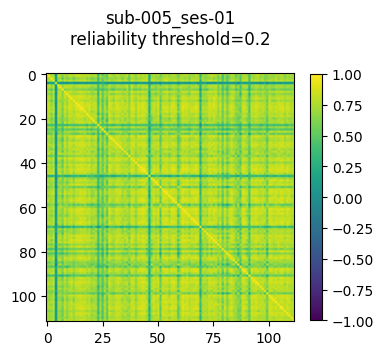

100%|██████████| 19173/19173 [00:01<00:00, 18105.65it/s]


rels (19173,)


100%|██████████| 112/112 [00:00<00:00, 5792.95it/s]


reliability threshold = 0.0


100%|██████████| 112/112 [00:03<00:00, 34.51it/s]


reliability threshold = 0.1


100%|██████████| 112/112 [00:02<00:00, 40.46it/s]


reliability threshold = 0.2


100%|██████████| 112/112 [00:01<00:00, 58.97it/s]


reliability threshold = 0.3


100%|██████████| 112/112 [00:01<00:00, 71.79it/s]


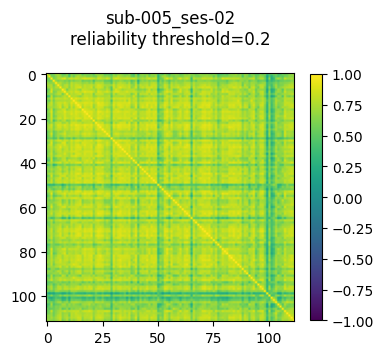

In [14]:
ses_rels = []
for i, s in enumerate(ses_list): 
    rels = compute_vox_rels(masked_betas[i], pairs_list[i], sub, s)
    ses_rels.append(rels)

In [15]:
print(masked_betas[0].shape, ses_rels[0].shape)
print(masked_betas[1].shape, ses_rels[1].shape)

(693, 19173) (19173,)
(693, 19173) (19173,)


In [16]:
(ses_rels[0]>.2).shape

(19173,)

In [18]:
# reliable_vox0 = masked_betas[0][:, ses_rels[0] > 0.2]
# reliable_vox1 = masked_betas[1][:, ses_rels[0] > 0.2]
# print(reliable_vox0.shape, reliable_vox1.shape)

# n_voxels = reliable_vox0.shape[1]
# print(n_voxels)

# print(np.diag(np.corrcoef(reliable_vox0, reliable_vox1, rowvar=True)).shape)

In [99]:
r_thresholds = np.arange(-0.2, 0.6, 0.1)
correlations = [None]*len(r_thresholds)

for i, thresh in enumerate(r_thresholds):
    reliable_vox0 = ses_vox[0][:, ses_rels[0] > thresh]  # Select reliable voxels from session 0
    reliable_vox1 = ses_vox[1][:, ses_rels[0] > thresh]  # Use the same selection for session 1

    # Compute correlation across voxels
    n_voxels = reliable_vox0.shape[1]
    print(np.diag(np.corrcoef(reliable_vox0, reliable_vox1, rowvar=True)).shape)
    correlations[i] = np.diag(np.corrcoef(reliable_vox0, reliable_vox1, rowvar=True)[:n_voxels, n_voxels:])
    # print(f"Threshold {thresh:.1f}: correlation = {correlations[i]:.4f}")

# plt.figure(figsize=(6, 4))
# plt.plot(r_thresholds, correlations, marker='o', linestyle='-')
# plt.xlabel("Reliability Threshold")
# plt.ylabel("Correlation between Sessions")
# plt.title(f"Correlation of Reliable Voxels Across {ses_list}")
# plt.grid(True)
# plt.show()

(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)
(1386,)


In [18]:
reliable_vox0.shape

(693, 133)

In [20]:
ses_vox[0][:,0].shape

(693,)

In [29]:
np.corrcoef(reliable_vox0.flatten(), reliable_vox1.flatten())

array([[1.        , 0.49275038],
       [0.49275038, 1.        ]])

In [32]:
voxelwise_corr = np.diag(np.corrcoef(reliable_vox0, reliable_vox1, rowvar=True)[:reliable_vox0.shape[1], reliable_vox0.shape[1]:])

In [33]:
voxelwise_corr.shape

(133,)

In [36]:
n_voxels = reliable_vox0.shape[1]

In [25]:
x.shape, y.shape

((19173,), (19173,))

In [26]:
x

array([False, False, False, ..., False, False, False])

In [31]:
best_fit

poly1d([ 1.09357818, -0.14054068])

-0.2 18957
-0.1 17278
0.0 12387
0.1 6433
0.2 2793
0.3 1196
0.4 458
0.5 133


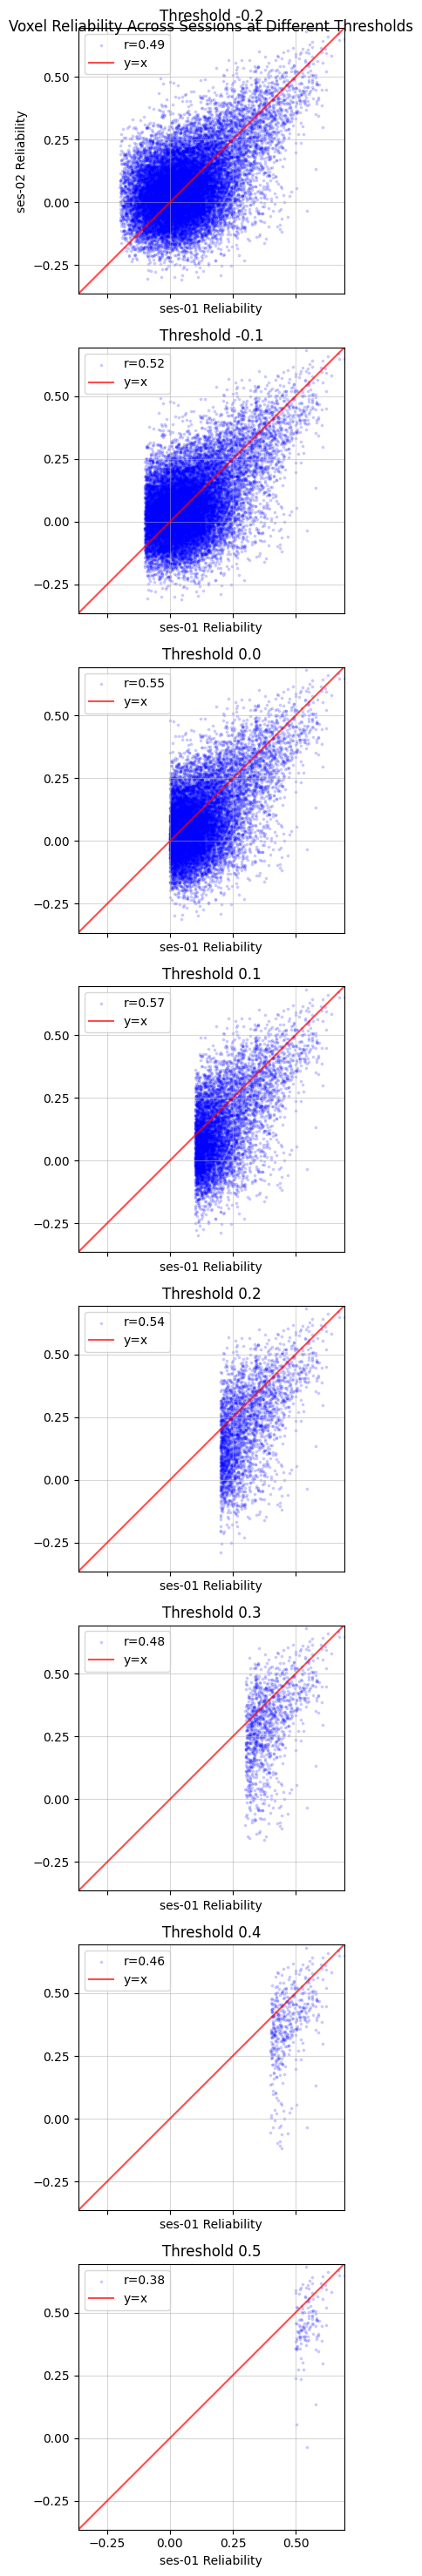

In [45]:
from matplotlib.ticker import MaxNLocator

r_thresholds = np.arange(-0.2, 0.6, 0.1)

# Determine global axis limits
reliability_min = min(ses_rels[0].min(), ses_rels[1].min())
reliability_max = max(ses_rels[0].max(), ses_rels[1].max())

# Create subplots
fig, axes = plt.subplots(len(r_thresholds), 1, figsize=(5, 30), sharex=True, sharey=True)

masks = []
for i, thresh in enumerate(r_thresholds):
    mask = ses_rels[0] > thresh
    masks.append(mask)
    x = ses_rels[0][mask]  # threshold reliability based on ses-01
    y = ses_rels[1][mask]  # compare to ses-02 reliabilities but using the ses-01 threshold
    print(f'{thresh:.1f}', x.shape[0])
    
    corr = np.corrcoef(x,y)[0,1]
    
    # Scatter plot
    axes[i].scatter(x, y, alpha=0.15, s=3, color='blue', label=f'r={corr:.2f}')
    
    axes[i].axline((0, 0), slope=1, color='r', alpha=0.7, label="y=x")

    # Set square aspect ratio and equal axis limits
    axes[i].set_xlim(reliability_min, reliability_max)
    axes[i].set_ylim(reliability_min, reliability_max)
    axes[i].set_aspect('equal', adjustable='box')  # Ensures square plots

    # Set tick marks to be evenly spaced
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Labels and title
    axes[i].set_title(f"Threshold {thresh:.1f}")
    axes[i].set_xlabel("ses-01 Reliability")
    if i == 0:
        axes[i].set_ylabel("ses-02 Reliability")
    
    axes[i].legend()
    axes[i].grid(alpha=0.5)

# Final layout adjustments
plt.suptitle("Voxel Reliability Across Sessions at Different Thresholds")
plt.tight_layout()
plt.show()

In [60]:
p = f"{glmsingle_path}/rel_mask_from_{ses_list[0]}_{sub}_{session_label}_task-{func_task_name}.npy"
np.save(p, masks)
print(f'saved to {p}!')

saved to /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01-02_task-C/rel_mask_from_ses-01_sub-005_ses-01-02_task-C.npy!


In [41]:
np.mean(reliable_vox0, axis=0).shape

(133,)

In [43]:
np.mean(reliable_vox0, axis=0)

array([ 1.6386663 ,  1.4280276 ,  1.3920997 ,  1.3363798 ,  1.943854  ,
        0.74288285,  0.93615633,  1.4037005 ,  1.1274223 ,  0.8784386 ,
        0.49452746,  1.2724034 ,  2.2910454 ,  1.3549308 ,  2.0667686 ,
        2.1804502 ,  2.5056558 ,  2.5716121 ,  2.8260975 ,  2.6643784 ,
        2.8739355 ,  0.38113588,  0.9321129 ,  1.4211788 ,  3.955809  ,
        4.7770267 ,  4.2579083 ,  3.009059  ,  2.7043023 ,  4.144559  ,
        3.9577436 ,  5.9161644 ,  3.6288464 ,  0.8444227 ,  7.9952016 ,
        8.865801  ,  6.547829  , 16.916792  ,  4.427135  ,  1.7675947 ,
        4.846907  ,  2.342955  ,  1.628623  ,  6.2282114 ,  1.8363528 ,
        3.5785336 ,  3.1818464 ,  7.939418  ,  2.8897402 ,  4.025549  ,
       10.610649  ,  3.7533045 ,  2.0139568 ,  5.85953   ,  3.5710258 ,
        7.842176  ,  2.133513  ,  1.9182532 ,  2.411353  ,  2.6803858 ,
        2.8071826 ,  1.7767298 ,  1.6415735 ,  1.7214755 ,  2.6603732 ,
        2.1634133 ,  1.4791054 ,  1.867356  ,  4.4034038 ,  1.66

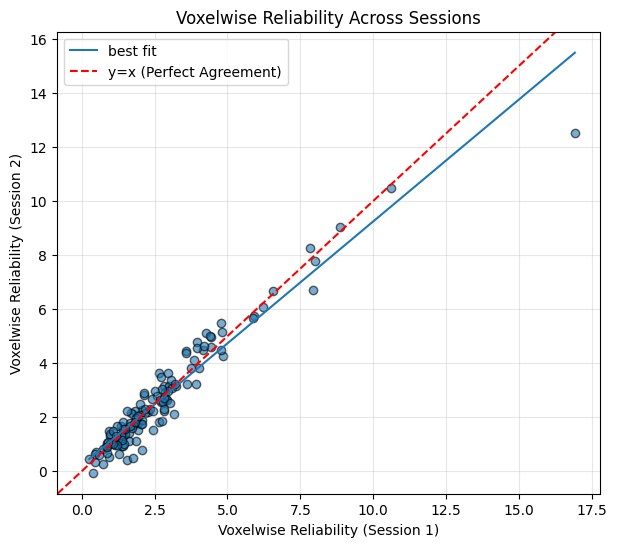

In [46]:
x = np.mean(reliable_vox0, axis=0)
y = np.mean(reliable_vox1, axis=0)

# Scatterplot
plt.figure(figsize=(7, 6))
plt.scatter(x, y, alpha=0.6, edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label='best fit')
plt.xlabel("Voxelwise Reliability (Session 1)")
plt.ylabel("Voxelwise Reliability (Session 2)")
plt.title("Voxelwise Reliability Across Sessions")
plt.axline((0, 0), slope=1, color='r', linestyle="--", label="y=x (Perfect Agreement)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
reliability_min = min(ses_rels[0].min(), ses_rels[1].min())
reliability_max = max(ses_rels[0].max(), ses_rels[1].max())

# Create subplots
fig, axes = plt.subplots(1, len(r_thresholds), figsize=(15, 4), sharex=True, sharey=True)

for i, thresh in enumerate(r_thresholds):
    # Select voxels that pass the threshold
    mask = ses_rels[0] > thresh
    x_thresh = ses_rels[0][mask]  # Reliability from session 0
    y_thresh = ses_rels[1][mask]  # Corresponding reliability from session 1

    # Compute correlation
    corr_coef = np.corrcoef(x_thresh, y_thresh)[0, 1]

    # Scatter plot
    sns.scatterplot(x=x_thresh, y=y_thresh, ax=axes[i], alpha=0.5, s=10, color='blue')

    # Best-fit line using polyfit/poly1d
    poly_fit = np.poly1d(np.polyfit(x_thresh, y_thresh, 1))
    axes[i].plot(np.unique(x_thresh), poly_fit(np.unique(x_thresh)), color='black', alpha=0.5)

    # Set square aspect ratio and equal axis limits
    axes[i].set_xlim(reliability_min, reliability_max)
    axes[i].set_ylim(reliability_min, reliability_max)
    axes[i].set_aspect('equal', adjustable='box')  # Ensures square plots

    # Set tick marks to be evenly spaced
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Labels and title
    axes[i].set_title(f"Threshold {thresh}\nCorr = {corr_coef:.2f}")
    axes[i].set_xlabel("Session 0 Reliability")
    if i == 0:
        axes[i].set_ylabel("Session 1 Reliability")

# Final layout adjustments
plt.suptitle("Voxel Reliability Across Sessions at Different Thresholds")
plt.tight_layout()
plt.show()

## does on/off r2 correlate with final reliability estimates?

In [28]:
def np2nib(data, mask):
    data_3d = np.zeros(mask.get_fdata().shape)  # shape includes voxels outside the brain
    data_3d[mask.get_fdata()!=0] = data  # fill the nonzero values (the ones in the brain) with the data; filter voxels that are in the brain
    return nib.Nifti1Image(data_3d, mask.affine)  # convert to nibabel object and return

In [29]:
# on_off['onoffR2'].shape, rels.shape, avg_mask.shape

In [31]:
# load on/off r2 and convert to nifti image using avg_mask affine
on_off = np.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/TYPEA_ONOFF.npz', allow_pickle=True)
avg_mask=nib.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/sub-001_ses-01_brain.nii.gz')

onoff_nib = np2nib(on_off['onoffR2'], avg_mask)
# onoff_nib = np2nib(utils.zscore(on_off['onoffR2']), avg_mask)

# get reliability mask from above
rels_nib = np2nib(rels, avg_mask)
# rels_nib = np2nib(utils.zscore(rels), avg_mask)

# confirm they're both in the same space

# plot both 
fig,ax=plt.subplots(1,1, figsize=(10,4))
d1 = plot_roi(onoff_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=onoff_nib.get_fdata().min(), vmax=onoff_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('onoff')
plt.show()

fig,ax=plt.subplots(1,1, figsize=(10,4))
d2 = plot_roi(rels_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=rels_nib.get_fdata().min(), vmax=rels_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('reliability')
plt.show()

ValueError: NumPy boolean array indexing assignment cannot assign 19173 input values to the 165240 output values where the mask is true

In [26]:
rels_nib.get_fdata().shape

(72, 94, 71)

In [27]:
np.where(rels_nib.get_fdata()!=0)[0]

array([ 3,  3,  3, ..., 69, 69, 69])

In [28]:
on_off

NpzFile '/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/TYPEA_ONOFF.npz' with keys: onoffR2, meanvol, betasmd

In [29]:
np.corrcoef(onoff_nib.get_fdata().flatten(), rels_nib.get_fdata().flatten())[0,1]

0.3703298672128314

In [30]:
print(f"onoff range: ({on_off['onoffR2'].min():.3f}, {on_off['onoffR2'].max():.3f})")
print(f"rels range: ({rels.min():.3f}, {rels.max():.3f})")

onoff range: (-0.000, 56.189)
rels range: (-0.643, 0.694)


In [32]:
glmsingle = np.load(f"{glmsingle_path}/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) 
vox = glmsingle['betasmd'].T
vox.shape

(1000, 165240)

## Is there an on/off r^2 threshold that isolates the majority of reliable voxels?

(165240,) (165240,)


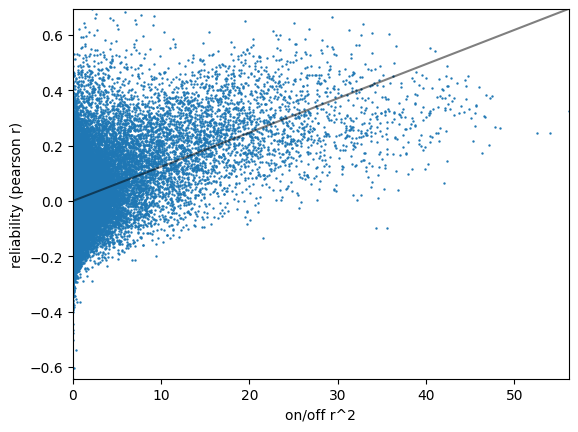

In [33]:
# scatterplot of r^2 threshold vs reliability
print(on_off['onoffR2'].shape, rels.shape)
x = on_off['onoffR2']
y = rels

r2_thresh = 0
mask = np.where(x>=r2_thresh)
x_thresh = x[mask]; y_thresh = y[mask]

plt.scatter(x_thresh, y_thresh, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.plot(np.unique(x_thresh), np.poly1d(np.polyfit(x_thresh, y_thresh, 1))(np.unique(x_thresh)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

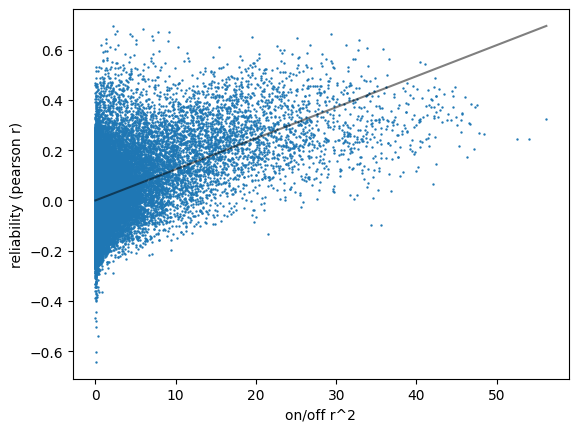

In [34]:
plt.scatter(x, y, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

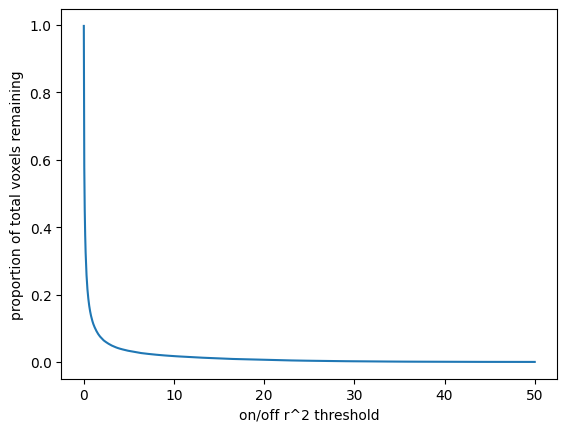

In [35]:
# at each onoff r2 threshold, what percentage of total voxels remain? 
r2_thresholds = np.linspace(0,50,1000)
# print('r2 thresh: proportion of voxels left (raw #)')
all_prop = []
for thresh in r2_thresholds:
    mask = np.where(x>=thresh)
    prop = x[mask].shape[0]/x.shape[0]
    # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
    all_prop.append(prop)
plt.plot(r2_thresholds, all_prop)
plt.xlabel('on/off r^2 threshold')
plt.ylabel('proportion of total voxels remaining')
plt.show()

In [36]:
baseline = np.sum(y>0.2)
print(f'baseline: {baseline} voxels with reliability > 0.2')
for r2 in np.arange(0,20,.5):
    num = np.sum(y[np.where(x>r2)]>0.2)
    print(f'{num} voxels ({(num/baseline):.2%}) with r^2 > {r2:.2f}')
    

baseline: 5174 voxels with reliability > 0.2
5169 voxels (99.90%) with r^2 > 0.00
3779 voxels (73.04%) with r^2 > 0.50
3484 voxels (67.34%) with r^2 > 1.00
3266 voxels (63.12%) with r^2 > 1.50
3093 voxels (59.78%) with r^2 > 2.00
2955 voxels (57.11%) with r^2 > 2.50
2833 voxels (54.75%) with r^2 > 3.00
2709 voxels (52.36%) with r^2 > 3.50
2612 voxels (50.48%) with r^2 > 4.00
2524 voxels (48.78%) with r^2 > 4.50
2439 voxels (47.14%) with r^2 > 5.00
2351 voxels (45.44%) with r^2 > 5.50
2267 voxels (43.82%) with r^2 > 6.00
2191 voxels (42.35%) with r^2 > 6.50
2120 voxels (40.97%) with r^2 > 7.00
2054 voxels (39.70%) with r^2 > 7.50
1994 voxels (38.54%) with r^2 > 8.00
1940 voxels (37.50%) with r^2 > 8.50
1874 voxels (36.22%) with r^2 > 9.00
1829 voxels (35.35%) with r^2 > 9.50
1758 voxels (33.98%) with r^2 > 10.00
1704 voxels (32.93%) with r^2 > 10.50
1645 voxels (31.79%) with r^2 > 11.00
1593 voxels (30.79%) with r^2 > 11.50
1550 voxels (29.96%) with r^2 > 12.00
1486 voxels (28.72%) with

85732 voxels with reliability > 0.0 without on/off r^2 threshold
24455 voxels with reliability > 0.1 without on/off r^2 threshold
5174 voxels with reliability > 0.2 without on/off r^2 threshold
1781 voxels with reliability > 0.3 without on/off r^2 threshold
669 voxels with reliability > 0.4 without on/off r^2 threshold


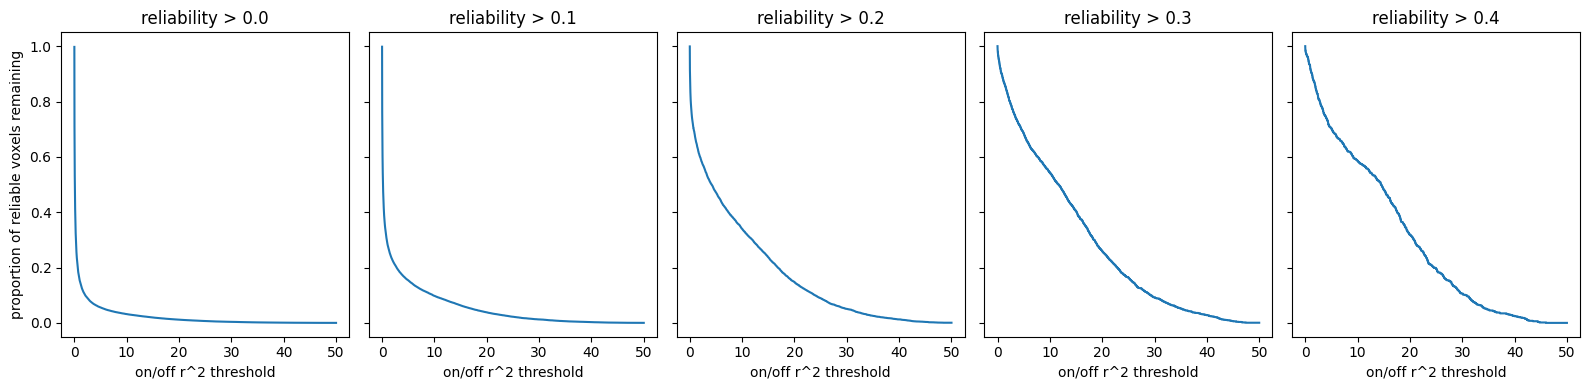

In [37]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,100000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_prop = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        # print(num)
        prop = num/baseline
        # print(f'{prop:.2%} voxels with reliability > {rel_thresh} at on/off r^2 > {r2_thresh}')
        # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
        all_prop.append(prop)
    ax[i].plot(r2_thresholds, all_prop)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('proportion of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()

85732 voxels with reliability > 0.0 without on/off r^2 threshold
24455 voxels with reliability > 0.1 without on/off r^2 threshold
5174 voxels with reliability > 0.2 without on/off r^2 threshold
1781 voxels with reliability > 0.3 without on/off r^2 threshold
669 voxels with reliability > 0.4 without on/off r^2 threshold


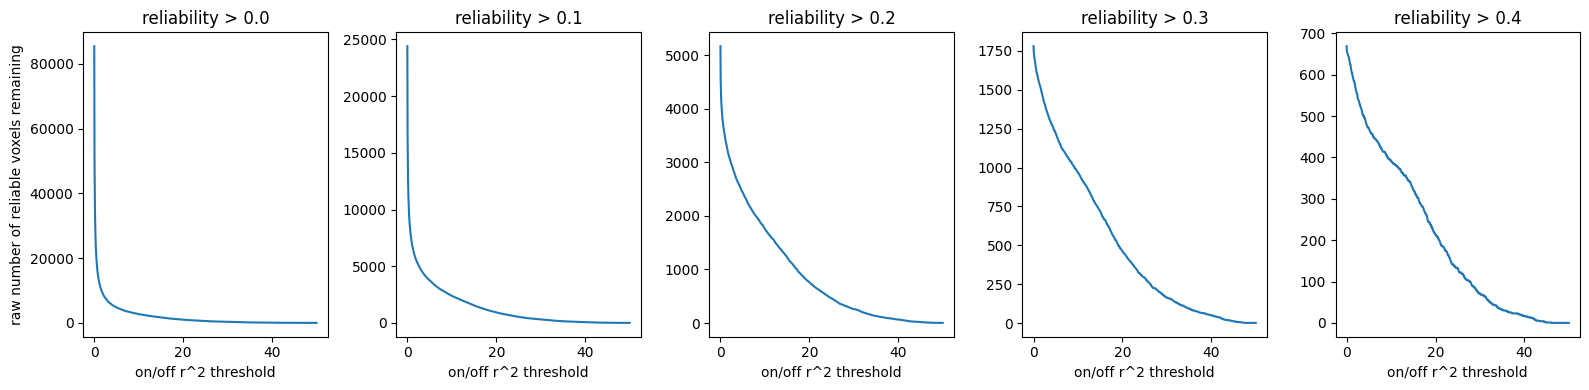

In [38]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,1000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=False)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_num = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        all_num.append(num)
    ax[i].plot(r2_thresholds, all_num)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('raw number of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()